In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import random
from random import shuffle
from efficientnet import tfkeras as efn
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
#bounding boxes are stored in a tsv file for each class. Below code read the tsv file as 
#pandas dataframe
tsv1 = '/home/b170007ec/Type_1_bbox.tsv'
tsv2 = '/home/b170007ec/Type_2_bboxes.tsv'
tsv3 = '/home/b170007ec/Type_3_bbox.tsv'
tsv1 = pd.read_csv(tsv1,sep='/t',header=None,names=['bboxes'])
tsv2 = pd.read_csv(tsv2,sep='/t',header=None,names=['bboxes'])
tsv3 = pd.read_csv(tsv3,sep='/t',header=None,names=['bboxes'])

/home/b170007ec/.conda/envs/AIR/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/home/b170007ec/.conda/envs/AIR/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/home/b170007ec/.conda/envs/AIR/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying

In [4]:
#getting image directories and  respective bboxes into a list
bboxes = []
img_dirs = []
for i,tsv in enumerate([tsv1,tsv2,tsv3]):
    for k in range(tsv.shape[0]):
        string = tsv.iloc[k].to_list()[0][7:]
        string = string.split(' ')
        img_dir = '/home/b170007ec/Datasets/Cervix Cancer/train/train/train/Type_'+str(i+1)+'/'+string[0]
        bbox = string[2:6]
        for l in range(4):
            bbox[l] = int(bbox[l])
        img_dirs.append(img_dir)
        bboxes.append(bbox)
temp = list(zip(bboxes,img_dirs))
random.shuffle(temp)
bboxes,img_dirs = zip(*temp)
bboxes = list(bboxes)
img_dirs = list(img_dirs)

/home/b170007ec/Datasets/Cervix Cancer/train/train/train/Type_3/590.jpg
/home/b170007ec/Datasets/Cervix Cancer/train/train/train/Type_2/1231.jpg
/home/b170007ec/Datasets/Cervix Cancer/train/train/train/Type_2/1198.jpg
/home/b170007ec/Datasets/Cervix Cancer/train/train/train/Type_1/396.jpg


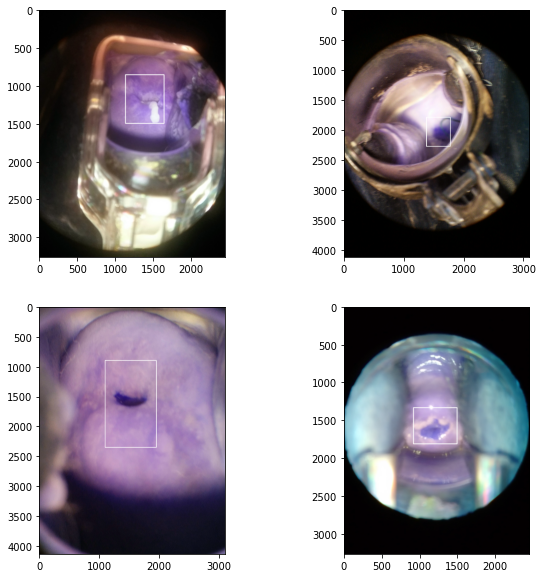

In [5]:
#random visualization
def ran_viz():
    images = []
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    indicies = random.choices([i for i in range(len(img_dirs))],k=4)
    for i,index in enumerate(indicies):
        img = img_dirs[index]
        print(img)
        bbox = bboxes[index]
        img = cv2.imread(img)
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]+bbox[0]
        ymax = bbox[3]+bbox[1]
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),10)
        ax[i//2][i%2].imshow(img)
ran_viz()

In [6]:
#parameters for detector
n_epochs = 40
BATCH_SIZE = 1
DISPLAY = 1
lr = 0.001
INPUT_SIZE = 1024
stride = 2
OUTPUT_SIZE = INPUT_SIZE//stride
n_category = 1
output_layer_n = n_category + 4

In [44]:
#generator for training and validating
class My_generator(Sequence):
    def __init__(self,image_names,bboxes,input_size = INPUT_SIZE,batch_size = BATCH_SIZE,is_train = False,stride = stride):
        self.image_names = image_names
        self.bboxes = bboxes
        self.stride = stride
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = self.input_size//self.stride
        self.is_train = is_train
        if self.is_train:
            self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.image_names)/float(self.batch_size)))
    def on_epoch_end(self):
        if self.is_train:
            temp = list(zip(self.image_names,self.bboxes))
            shuffle(temp)
            self.image_names,self.bboxes = zip(*temp)
    def __getitem__(self,idx):
        batch_x = self.image_names[self.batch_size*idx:self.batch_size*(idx+1)]
        batch_y = self.bboxes[self.batch_size*idx:self.batch_size*(idx+1)]
        assert len(batch_x) == len(batch_y)
        if self.is_train:
            return self.train_generator(batch_x,batch_y)
        else:
            return self.valid_generator(batch_x,batch_y)
    def train_generator(self,batch_x,batch_y):
        X = []
        heatmaps = []
        Y = []
        num = 0
        output_height,output_width = self.output_size,self.output_size
        for k,image_dir in enumerate(batch_x):
            bboxs = batch_y[k]
            img = cv2.imread(image_dir)
            im_h,im_w,c = img.shape[0],img.shape[1],img.shape[2]
            img = cv2.resize(img,(self.input_size,self.input_size))
            '''each image will be flipped in 4 possible ways nd added to traiing list'''
            output1 = np.zeros((self.output_size,self.output_size,output_layer_n+n_category))
            output2 = np.zeros((self.output_size,self.output_size,output_layer_n+n_category))
            output3 = np.zeros((self.output_size,self.output_size,output_layer_n+n_category))
            output4 = np.zeros((self.output_size,self.output_size,output_layer_n+n_category))

            for bbox in [bboxs]:
                xc = (bbox[0]) + (bbox[2]/2)
                yc = (bbox[1]) + (bbox[3]/2)
                width = bbox[2] 
                height = bbox[3] 
                '''scaling to the output sizes'''
                xc,yc,width,height = xc*(output_width/im_w),yc*(output_height/im_h),width*(output_width/im_w),height*(output_height/im_h)
                category = 0
                '''heatmap which has 1 one at centre of the object, velues near to 1 at points near to centrepoint
                and rest are 0's'''
                heatmap1=((np.exp(-(((np.arange(output_width)-xc)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(output_height)-yc)/(height/10))**2)/2)).reshape(-1,1))
                output1[:,:,0] = np.maximum(heatmap1[:,:],output1[:,:,0])
                for i in range(n_category):
                    output1[int(yc//1),int(xc//1),i+1] = 1
                    output1[int(yc//1),int(xc//1),n_category+1] = yc%1
                    output1[int(yc//1),int(xc//1),n_category+2] = xc%1
                    output1[int(yc//1),int(xc//1),n_category+4] = width/output_width
                    output1[int(yc//1),int(xc//1),n_category+3] = height/output_height
                    
                xc2 = xc 
                yc2 = self.output_size-yc
                heatmap2=((np.exp(-(((np.arange(output_width)-xc2)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(output_height)-yc2)/(height/10))**2)/2)).reshape(-1,1))
                output2[:,:,0] = np.maximum(heatmap2[:,:],output2[:,:,0])
                for i in range(n_category):
                    output2[int(yc2//1),int(xc2//1),i+1] = 1
                    output2[int(yc2//1),int(xc2//1),n_category+1] = yc2%1
                    output2[int(yc2//1),int(xc2//1),n_category+2] = xc2%1
                    output2[int(yc2//1),int(xc2//1),n_category+4] = width/output_width
                    output2[int(yc2//1),int(xc2//1),n_category+3] = height/output_height
                    
                xc3 = self.output_size - xc 
                yc3 = yc
                heatmap3=((np.exp(-(((np.arange(output_width)-xc3)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(output_height)-yc3)/(height/10))**2)/2)).reshape(-1,1))
                output3[:,:,0] = np.maximum(output3[:,:,0],heatmap3[:,:])
                for i in range(n_category):
                    output3[int(yc3//1),int(xc3//1),i+1] = 1
                    output3[int(yc3//1),int(xc3//1),n_category+1] = yc3%1
                    output3[int(yc3//1),int(xc3//1),n_category+2] = xc3%1
                    output3[int(yc3//1),int(xc3//1),n_category+4] = width/output_width
                    output3[int(yc3//1),int(xc3//1),n_category+3] = height/output_height

                xc4 = self.output_size-xc 
                yc4 = self.output_size-yc
                heatmap4=((np.exp(-(((np.arange(output_width)-xc4)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(output_height)-yc4)/(height/10))**2)/2)).reshape(-1,1))
                output4[:,:,0] = np.maximum(output4[:,:,0],heatmap4[:,:])
                for i in range(n_category):
                    output4[int(yc4//1),int(xc4//1),i+1] = 1
                    output4[int(yc4//1),int(xc4//1),n_category+1] = yc4%1
                    output4[int(yc4//1),int(xc4//1),n_category+2] = xc4%1
                    output4[int(yc4//1),int(xc4//1),n_category+4] = width/output_width
                    output4[int(yc4//1),int(xc4//1),n_category+3] = height/output_height
            num = num + 1
            image2 = cv2.flip(img,0)
            image3 = cv2.flip(img,1)
            image4 = cv2.flip(img,-1)
            X.append(image2)
            X.append(img)
            X.append(image3)
            X.append(image4)
            Y.append(output2)
            Y.append(output1)
            Y.append(output3)
            Y.append(output4)
        X = np.asarray(X, np.float32)/255
        Y = np.asarray(Y, np.float32)
        assert X.shape[0] == Y.shape[0]
        return X,Y
    def valid_generator(self,batch_x,batch_y):
        X = []
        heatmaps = []
        Y = []
        output_height,output_width = self.output_size,self.output_size
        for bbox,image_dir in zip(batch_y,batch_x):
            img = cv2.imread(image_dir)
            im_h,im_w,c = img.shape[0],img.shape[1],img.shape[2]
            img = cv2.resize(img,(self.input_size,self.input_size))
            output1 = np.zeros((self.output_size,self.output_size,output_layer_n+n_category))

            for bbox in [bbox]:
                xc = (bbox[0]) + (bbox[2]/2)
                yc = (bbox[1]) + (bbox[3]/2)
                width = bbox[2]
                height = bbox[3]
                xc,yc,width,height = xc*(output_width/im_w),yc*(output_height/im_h),width*(output_width/im_w),height*(output_height/im_h)
                category = 0
                heatmap1=((np.exp(-(((np.arange(output_width)-xc)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(output_height)-yc)/(height/10))**2)/2)).reshape(-1,1))
                output1[:,:,0] = np.maximum(heatmap1[:,:],output1[:,:,0])
                for i in range(n_category):
                    output1[int(yc//1),int(xc//1),i+1] = 1
                    output1[int(yc//1),int(xc//1),n_category+1] = yc%1
                    output1[int(yc//1),int(xc//1),n_category+2] = xc%1
                    output1[int(yc//1),int(xc//1),n_category+4] = width/output_width
                    output1[int(yc//1),int(xc//1),n_category+3] = height/output_height
            X.append(img)
            Y.append(output1)
        X = np.asarray(X, np.float32)/255
        Y = np.asarray(Y, np.float32)
        
        return X,Y


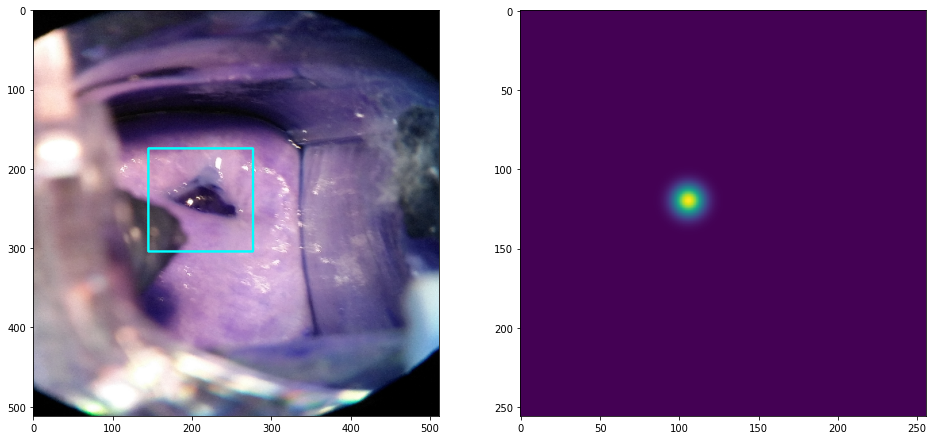

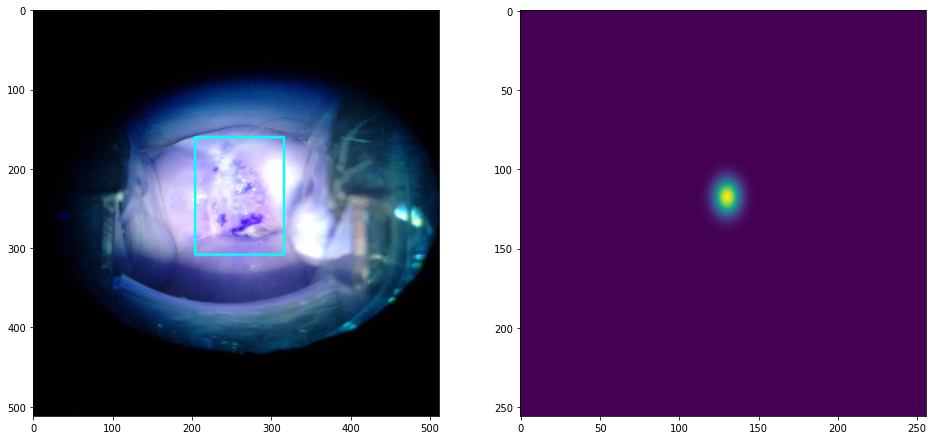

In [39]:
#testing the generator
def test(i):
    mygen = My_generator(img_dirs,bboxes,batch_size=1, is_train = True)
    X,Y = mygen.__getitem__(15)
    X = X[i]
    Y = Y[i]
    X = np.asarray(np.ceil(X*255) ,np.uint8)
    heatmap = Y[:,:,0]
    points = np.argwhere(Y[:,:,1]==1)
    for y,x in points:
        offy = Y[y,x,2]
        offx = Y[y,x,3]
        width = Y[y,x,5]*(INPUT_SIZE/stride)
        height = Y[y,x,4]*(INPUT_SIZE/stride)
        xc = x+offx
        yc = y+offy
        xmin = int((xc-(width/2))*stride)
        ymin = int((yc-(height/2))*stride)
        xmax = int((xc+(width/2))*stride)
        ymax = int((yc+(height/2))*stride)
        cv2.rectangle(X, (xmin, ymin), (xmax, ymax), (0,255,255), 2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].imshow(X)
    ax[1].imshow(heatmap)
test(0)
test(1)

In [40]:
def build_fpn(features,num_channels,wbifpn,kernel_size=2):
    p4,p5,p6,p7 = features
    #column1
    p6 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6)
    p5 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5)
    p4 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4)
    
    p7 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p7)
    p7_resize = BatchNormalization()(p7)
    p7_resize = MaxPool2D((kernel_size,kernel_size))(p7_resize)
    if wbifpn:
        p6_td = Fuse()([p6,p7_resize])
    else:
        p6_td = Add()([p6,p7_resize])
    p6_td = Conv2D(num_channels,(3,3),kernel_initializer = 'glorot_uniform',activation='relu',padding='same')(p6_td)
    p6_td = BatchNormalization()(p6_td)
    p6_td = MaxPool2D((2,2),padding = 'same',strides = 1)(p6_td)
    p6_td_resize = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6_td)
    p6_td_resize = BatchNormalization()(p6_td_resize)
    
    p6_td_resize = MaxPool2D((kernel_size,kernel_size))(p6_td_resize) 
    if wbifpn:
        p5_td = Fuse()([p5,p6_td_resize])
    else:
        p5_td = Add()([p5,p6_td_resize])
    p5_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_td)
    p5_td = BatchNormalization()(p5_td)
    p5_td = MaxPool2D((2,2),padding='same',strides = 1)(p5_td)
    p5_td_resize = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_td)
    p5_td_resize = BatchNormalization()(p5_td_resize)
    p5_td_resize = MaxPooling2D((kernel_size,kernel_size))(p5_td_resize)
    if wbifpn:
        p4_td = Fuse()([p4,p5_td_resize])
    else:
        p4_td = Add()([p4,p5_td_resize])
    p4_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4_td)
    p4_td = MaxPool2D((2,2),padding='same',strides = 1)(p4_td)
    p4_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4_td)
    p4_U = BatchNormalization()(p4_U)
    p5_U = UpSampling2D((kernel_size,kernel_size))(p4_U)
    if wbifpn:
        p5_U = Fuse()([p5,p5_td,p5_U])
    else:
        p5_U = Add()([p5,p5_td,p5_U])
    p5_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_U)
    p5_U = BatchNormalization()(p5_U)
    p6_U = UpSampling2D((kernel_size,kernel_size))(p5_U)
    if wbifpn:
        p6_U = Fuse()([p6,p6_td,p6_U])
    else:
        p6_U = Add()([p6,p6_td,p6_U])
    p6_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6_U)
    p6_U = BatchNormalization()(p6_U)
    p7_U = UpSampling2D((kernel_size,kernel_size))(p6_U)
    if wbifpn:
        p7_U = Fuse()([p7,p7_U])
    else:
        p7_U = Add()([p7,p7_U])
    p7_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p7_U)
    p7_U = BatchNormalization()(p7_U)
    return (p4_U,p5_U,p6_U,p7_U)

In [41]:
class Fuse(tf.keras.layers.Layer):
    '''Fusion layer'''
    def __init__(self, epsilon=1e-4, **kwargs):
        super(Fuse, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        num_in = len(input_shape)
        self.w = self.add_weight(name=self.name,
                                 shape=(num_in,),
                                 initializer=tf.keras.initializers.constant(1 / num_in),
                                 trainable=True,
                                 dtype=tf.float32)

    def call(self, inputs, **kwargs):
        w = tf.keras.activations.relu(self.w)
        x = tf.reduce_sum([w[i] * inputs[i] for i in range(len(inputs))], axis=0)
        x = x / (tf.reduce_sum(w) + self.epsilon)
        return x
    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = super(Fuse, self).get_config()
        config.update({
            'epsilon': self.epsilon
        })
        return config
    
def create_model(input_shape ,wbifpn=False):
    '''model'''
    effnet = efn.EfficientNetB4(input_shape=input_shape,weights=None,include_top = False)
    p4 = effnet.get_layer('block2a_activation').output
    p5 = effnet.get_layer('block3a_activation').output
    p6 = effnet.get_layer('block4a_activation').output
    p7 = effnet.get_layer('block7a_activation').output
    features = (p7,p6,p5,p4)
    features = build_fpn(features,8,wbifpn)
    features = build_fpn(features,16,wbifpn)
    features = build_fpn(features,32,wbifpn)
    features = list(features)
    for i in range(1,4):
        feature_curr = features[i]
        feature_past = features[i-1]
        feature_past_up = UpSampling2D((2,2))(feature_past)
        feature_past_up = Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(feature_past_up)
        if wbifpn:
            feature_final = Fuse(name='final{}'.format(str(i)))([feature_curr,feature_past_up])
        else:
            feature_final = Add(name='final{}'.format(str(i)))([feature_curr,feature_past_up])
        features[i] = feature_final
    if stride == 2:
        features[-1] = UpSampling2D((2,2))(features[-1])
        features[-1] = Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='glorot_uniform')(features[-1])
    out = Conv2D(5,(3,3),activation='sigmoid',kernel_initializer='glorot_uniform',padding='same')(features[-1])
    zeros = tf.expand_dims(tf.zeros_like(out[...,0]),axis=-1)
    out_concat = tf.concat([zeros,out],axis = -1)
    prediction_model=tf.keras.models.Model(inputs=[effnet.input],outputs=out)
    model = Model(inputs = [effnet.input],outputs = out_concat)
    return model,prediction_model

In [42]:
def focal_loss(gamma,gamma2,y_true,y_pred,heatmaps):
    '''focal loss'''
    y_pred = K.clip(y_pred,1e-5,1-1e-5)
    loglik = 2*y_true*((1-y_pred)**gamma)*K.log(y_pred) +(1-y_true)*((1-heatmaps)**gamma2)*(y_pred**gamma)*K.log(1-y_pred)
    cls_loss = -K.sum(loglik,axis=0)
    return cls_loss

def loss_fn(gamma1,gamma2):
    '''final combined loss and supporting functions'''
    def final_loss(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]))
        N = K.sum(mask)
        heatmaps = K.batch_flatten(y_true[...,0])
        cls_pred = K.batch_flatten(y_pred[...,1])
        cls_pred = K.clip(cls_pred,1e-7,1-1e-7)
        cls_true = K.batch_flatten(y_true[...,1])

        cls_loss = K.sum(focal_loss(gamma1,gamma2,cls_true,cls_pred,heatmaps))/N
    
        offy_pred = K.batch_flatten(y_pred[...,2])
        offx_pred = K.batch_flatten(y_pred[...,3])
        offy_true = K.batch_flatten(y_true[...,2])
        offx_true = K.batch_flatten(y_true[...,3])
        offloss = K.abs(offx_pred*mask-offx_true) + K.abs(offy_pred*mask-offy_true)
        offloss = K.sum(offloss)/N
    
        sizey_true = K.batch_flatten(y_true[...,4])
        sizey_pred = K.batch_flatten(y_pred[...,4])
        sizex_true = K.batch_flatten(y_true[...,5])
        sizex_pred = K.batch_flatten(y_pred[...,5])
        y_mask = tf.cast(sizey_pred>0.4,dtype=tf.float32)
        x_mask = tf.cast(sizex_pred>0.4,dtype=tf.float32)
        y_weight = y_mask*sizey_pred
        x_weight = x_mask*sizex_pred
        size_loss = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1+x_weight)+K.abs(sizey_pred*mask-sizey_true)*(1+y_weight))/N 
        loss = (1.5*cls_loss+1*offloss+10*size_loss)
        return loss
    return final_loss

def cls_metric(gamma1,gamma2):
    def closs(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]))
        N = K.sum(mask)
        heatmaps = K.batch_flatten(y_true[...,0])
        cls_pred = K.batch_flatten(y_pred[...,1])
        cls_pred = K.clip(cls_pred,1e-7,1-1e-7)
        cls_true = K.batch_flatten(y_true[...,1])
        cls_loss = K.sum(focal_loss(gamma1,gamma2,cls_true,cls_pred,heatmaps))/N
        return cls_loss
    return closs
    
def off_loss(y_true,y_pred):
    mask = K.batch_flatten(K.sign(y_true[...,4]))
    N = K.sum(mask)
    offy_pred = K.batch_flatten(y_pred[...,2])
    offx_pred = K.batch_flatten(y_pred[...,3])
    offy_true = K.batch_flatten(y_true[...,2])
    offx_true = K.batch_flatten(y_true[...,3])
    offloss = K.abs(offx_pred*mask-offx_true) + K.abs(offy_pred*mask-offy_true)
    offloss = K.sum(offloss)/N
    return offloss
def size_metric():
    def sloss(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]))
        N = K.sum(mask)
        sizey_true = K.batch_flatten(y_true[...,4])
        sizey_pred = K.batch_flatten(y_pred[...,4])
        sizex_true = K.batch_flatten(y_true[...,5])
        sizex_pred = K.batch_flatten(y_pred[...,5])
        y_mask = tf.cast(sizey_pred>0.4,dtype=tf.float32)
        x_mask = tf.cast(sizex_pred>0.4,dtype=tf.float32)
        y_weight = y_mask*sizey_pred
        x_weight = x_mask*sizex_pred
        size_loss = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1+x_weight)+K.abs(sizey_pred*mask-sizey_true)*(1+y_weight))/N#size_loss2 = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1-sizex_true)*mask+K.abs(sizey_pred*mask-sizey_true)*(1-sizey_true)*mask,axis=-1)
        #size_loss = 0.8*size_loss1+0.2*size_loss2
        return size_loss
    return sloss
def build_model(input_shape,gamma1=1.5,gamma2=3.0,lr=lr):
    model,_ = create_model(input_shape)
    optimizer = Adam(lr = lr)
    model.compile(loss = loss_fn(gamma1,gamma2),optimizer = optimizer,metrics = [off_loss,size_metric(),cls_metric(gamma1,gamma2)])
    return model

In [ ]:
#learning rate scheduler
def lrs(epoch):
    lr = 0.001
    if epoch >= 20: lr = 0.0002
    return lr

lr_schedule = LearningRateScheduler(lrs)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 5, verbose = 1)
print('no of available datapoints : {}'.format(4*len(img_dirs)))
#splitting
curT = c_img_dirs[300:]
bboxesT = c_bboxes[300:]
curV = c_img_dirs[:300]
bboxesV = c_bboxes[:300]
#generators
train_gen = My_generator(curT,bboxesT,batch_size = BATCH_SIZE,is_train=True)
val_gen = My_generator(curV,bboxesV,batch_size = BATCH_SIZE,is_train = False)
model = build_model((INPUT_SIZE,INPUT_SIZE,3))
STEPS_PER_EPOCH = len(curT)//(BATCH_SIZE*4)
name = 'trained.h5'
checkpoint = ModelCheckpoint(name,monitor = 'val_loss', save_best_only = True, verbose = 1, period = 1)
#training
history = model.fit_generator(train_gen,epochs = n_epochs ,verbose = DISPLAY,steps_per_epoch = STEPS_PER_EPOCH,validation_data = val_gen,shuffle = True,validation_steps = len(curV)//(BATCH_SIZE*4),callbacks = [lr_schedule,checkpoint,early_stopping])